In [1]:
%matplotlib inline
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from selfregulation.utils.plot_utils import format_num
from statsmodels.stats.stattools import medcouple

from selfregulation.utils.data_preparation_utils import transform_remove_skew, remove_outliers, remove_correlated_task_variables

/media/Data/Ian/miniconda/envs/SO/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/media/Data/Ian/miniconda/envs/SO/lib/python3.5/site-packages/expanalysis/experiments/survey_processing.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  reference_scores = pandas.DataFrame.from_csv(os.path.join(file_loc,'survey_subscale_reference.csv'))


In [2]:
data = get_behav_data()
selected_variables = get_behav_data()
clean = get_behav_data(file = 'meaningful_variables_clean.csv')
imputed = get_behav_data(file = 'meaningful_variables_imputed.csv')

In [3]:
def get_outliers(cleaned, orig, variables):
    outliers = cleaned[variables].isnull() ^ orig[variables].isnull()
    return outliers

def plot_outliers(cleaned, orig, variables):
    outliers = get_outliers(cleaned, orig, variables)
    num_with_outliers = np.sum(outliers.mean()>0)
    outliers = outliers.loc[:,outliers.mean()>0]
    f, axes = plt.subplots(ceil(num_with_outliers/3), 3, figsize=(12,num_with_outliers))
    axes = f.get_axes()
    i=0
    variables=outliers.mean().sort_values().index[::-1]
    for name, var in orig[variables].iteritems():
        ax = axes[i]
        outlier = outliers[name]
        var_kept = var[~outlier]
        var_outliers = var[outlier]
        sns.stripplot(var_kept, ax=ax, size=4, alpha=.5)
        sns.stripplot(var_outliers, color='r', ax=ax, size=3)
        ax.set_title('\n'.join(name.split('.')))
        ax.set_xlabel('')
        ax.text(.3, .8, 'Outlier %%: %s' % format_num(outlier.mean()), 
                transform=ax.transAxes, fontsize=12)
        i+=1
    plt.subplots_adjust(wspace=.5, hspace=.5)

### Procedure 
- transform variables that are skewed. 
- drop variables if they *would still be skewed* after following outliers removal
- remove outliers from all variables except the first group

In [4]:
selected_variables_clean_transformed = transform_remove_skew(selected_variables)
selected_variables_clean = remove_outliers(selected_variables_clean_transformed)

/media/Data/Ian/Experiments/Self_Regulation_Ontology/selfregulation/utils/data_preparation_utils.py:577: RuntimeWarning: invalid value encountered in less
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan
/media/Data/Ian/Experiments/Self_Regulation_Ontology/selfregulation/utils/data_preparation_utils.py:577: RuntimeWarning: invalid value encountered in greater
  data_mat[np.logical_or((data_mat<lowlimit), (data_mat>highlimit))] = np.nan


****************************************
** Successfully transformed 26 negatively skewed variables:
adaptive_n_back.mean_load
angling_risk_task_always_sunny.release_coef_of_variation
bickel_titrator.hyp_discount_rate_large
bickel_titrator.hyp_discount_rate_medium
bickel_titrator.hyp_discount_rate_small
bis11_survey.Motor
choice_reaction_time.hddm_non_decision
columbia_card_task_cold.gain_sensitivity
columbia_card_task_hot.gain_sensitivity
directed_forgetting.proactive_interference_hddm_drift
dospert_eb_survey.health_safety
dot_pattern_expectancy.hddm_thresh
holt_laury_survey.beta
kirby.hyp_discount_rate_large
kirby.hyp_discount_rate_medium
kirby.hyp_discount_rate_small
motor_selective_stop_signal.hddm_thresh
shape_matching.hddm_thresh
shift_task.model_beta
simple_reaction_time.avg_rt
stim_selective_stop_signal.hddm_thresh
stop_signal.SSRT_high
stop_signal.hddm_thresh
stroop.hddm_thresh
threebytwo.hddm_thresh
tower_of_london.avg_move_time
****************************************
******

### Let's compare both of these approaches now

#### Skew

All approaches remove skew, obviously. Every kept variable at the end is within our skew thresholds

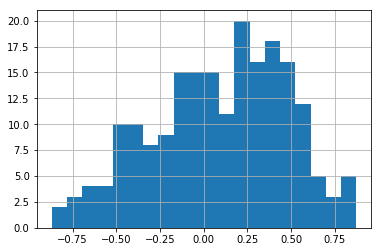

In [5]:
# evaluating skew
selected_variables_clean.skew().hist(bins=20, alpha=1)

In [6]:
def remove_suffix(df):
    df.columns = ['.'.join(i.split('.')[:-1]) if 'logTr' in i else i for i in df.columns]

#### Procedure

After skewed variables are transformed all variables have outliers removed. The blue distribution here represents the *transformed* distribution. Only variables with at least one outlier are plotted, and they are sorted based on the percent of outliers removed.

There is one outlier case which I have dug into after these plots.

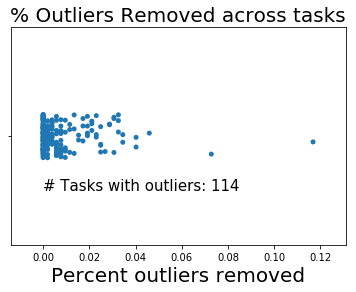

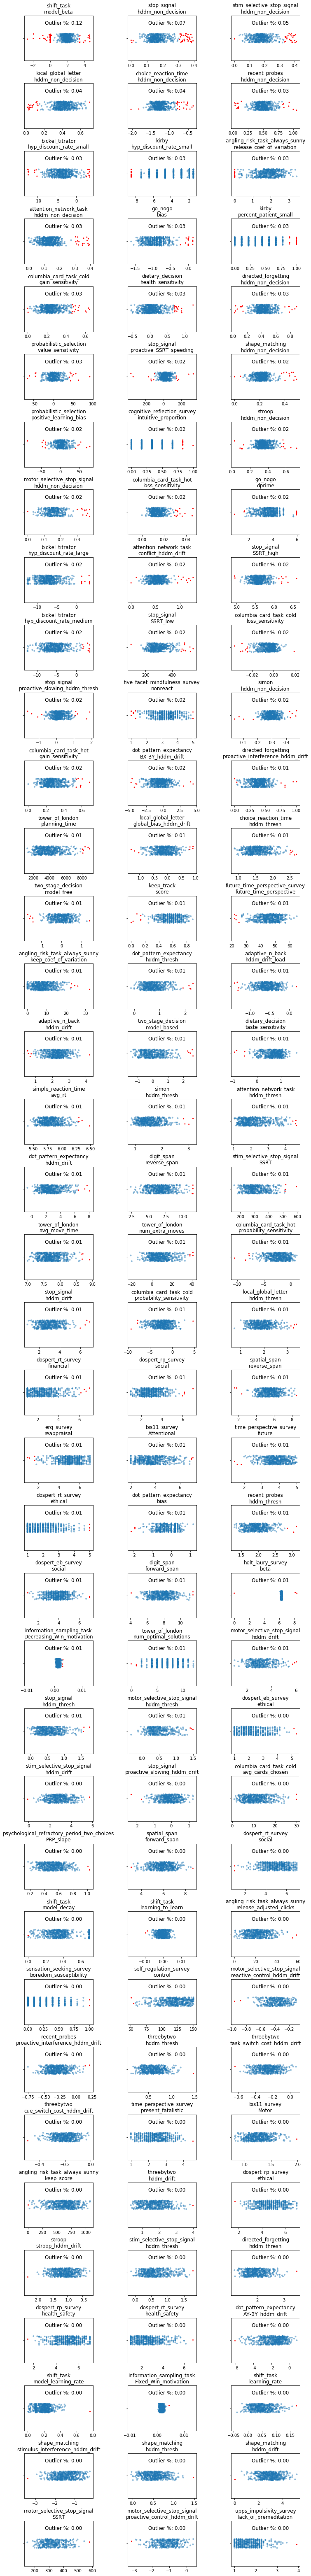

In [7]:
tmp = selected_variables_clean.copy()
remove_suffix(tmp)
tmp2 = selected_variables_clean_transformed
remove_suffix(tmp2)
outliers = get_outliers(tmp, tmp2, tmp.columns)
# summary
tasks_with_outliers = np.sum(outliers.sum()>0)
sns.stripplot(outliers.mean()); plt.xlabel('Percent outliers removed', fontsize=20)
plt.text(0, .25, "# Tasks with outliers: %s" % format_num(tasks_with_outliers),
        fontsize=15)
plt.title('% Outliers Removed across tasks', fontsize=20)
# individual
plot_outliers(tmp, tmp2, tmp.columns)

One variable seemed odd. It was the shift task model-beta. It seems that a decent number of subjects have a beta value=1 (the starting value). At the same time, the variable is skewed, so it is transformed, making all of those 1's 0's. One option is to remove the extreme outliers before transforming. The variable will no longer be skewed and won't be trasnformed. Instead, I am going to just leave the variable as is, as I don't want to customize the procedure for individual variables

Text(0.5, 1.0, 'Model Beta before transform')

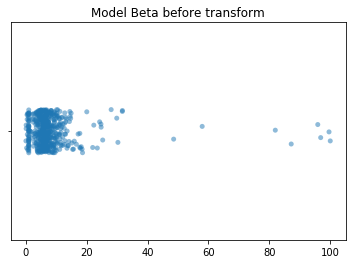

In [8]:
sns.stripplot(selected_variables.filter(regex='model_beta'), alpha=.5)
plt.title('Model Beta before transform')

Text(0.5, 1.0, 'Model Beta after transform')

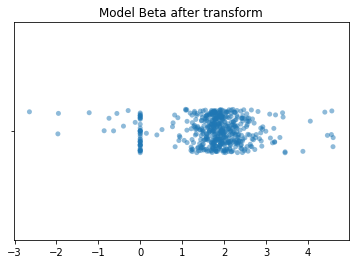

In [9]:
sns.stripplot(np.log(selected_variables.filter(regex='model_beta')), alpha=.5)
plt.title('Model Beta after transform')

# Evaluate all distributions

In [10]:
# look clean and imputed data
clean = get_behav_data(file = 'meaningful_variables_clean.csv')
imputed = get_behav_data(file = 'meaningful_variables_imputed.csv')

clean_melted=clean.melt().assign(stage='clean')
impute_melted=imputed.melt().assign(stage='imputed')
final = pd.concat([clean_melted, impute_melted])
# remove missing values
final = final.replace([np.inf, -np.inf], np.nan)
final.dropna(inplace=True)

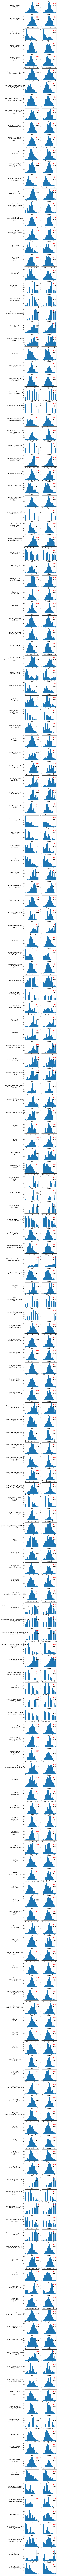

In [11]:
%matplotlib inline
n_rows=clean.shape[1]
f, axes = plt.subplots(n_rows, 2, figsize=(7, n_rows*3))
for row, name in enumerate(sorted(final.variable.unique())):
    for col, stage in enumerate(['clean','imputed']):
        subset = final.query('variable == "%s" and stage == "%s"' % (name, stage))
        if len(subset) > 0:
            axes[row][col].hist(subset['value'], bins=20)
            axes[row][0].set_ylabel(('\n').join(name.split('.')), fontsize=15,
                                   rotation=0, labelpad=100)
            axes[row][col].set_title(str(stage))
            axes[row][col].text(.75,.6,format_num(subset.value.skew()),
                                fontsize=15,
                                color='black',
                               transform = axes[row][col].transAxes)
            axes[row][col].text(.75,.8,format_num(float(medcouple(subset.value))),
                                fontsize=15,
                                color='red',
                               transform = axes[row][col].transAxes)
plt.subplots_adjust(hspace=.2)